### Motivation
Broadly speaking, I'm interested in dissecting how contextual knowledge is stored and recalled by a LLM model when required to answer a question or generate relevant text. By contextual knowledge, I mean the information that we provide in the context, rather than global factual knowledge that are stored in model's parameter. For example, "Eiffel Tower is in Rome" is a global factual knowledge stored in model parameters. Whereas, a text describing a person that we feed into the model contains contextual/localized knowledge which are not stored in model parameters, but are used to answer questions about the person or just generate relevant text. It is also pertinent to the phenomenon of variable binding in programming languages, i.e. how does LLM keep track of the information associated to an agent and recall it at appropriate time.

In order to experiment how contextual knowledge is stored or recalled, I'm planning to use code expression (mainly addition, for now) experimental setup, because of following reasons:
 - I think it represents a similar situation in a simpler setting. Similar to storing and using traits of a person to answer a question or to generate relevant text, in this setting, values of the variables need to be stored, fetched, and operated on, to answer questions. More specially, I would posit that the computation, in terms of manipulating their respecting contextual knowledge, of following context would be similar because both involves variable binding:
    - Alice lives in London. Bob lives in Manchester. How far does Alice live from bob?
    - `x = 5; y = 3; x - y =`
 - It seems computationally more feasible to study code expression setting. But I would definitely like to explore the general situation in future and confirm my intuition that contextual knowledge manipulation in the code expression setting would be similar to other general cases.

*Disclaimer*: I'm not using `TransformerLens`, instead I'm using Prof. David Bau's `baukit`. There is no specific reason for that. At this point in time, I'm just more familiar with `baukit` then `TransformerLens`. But I'll be learning more about `TransformerLens` soon, so that shouldn't be a problem. In addition, I'm using the `Llama-7B` model for the following exploration, so to re-execute the code you would need to have its weights. Additionally, since I've plotted a lot of causal tracing figures and extended some existing code from the ROME paper, I've decide to push this notebook and supporting code as a Github repo, rather than stand-alone colab. Most of the python libraries are the standard ones, except for the `baukit`, which can be installed in using following code.

Link to Google Doc with [Summary of Results](https://docs.google.com/document/d/1awdjd0vq-hagzlb5MRuWUlLoAl17PbRbdO7M4yCYbGc/edit?usp=sharing).

### Setup

In [17]:
%pip install git+https://github.com/davidbau/baukit

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-ig1hnf97
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-ig1hnf97
  Resolved https://github.com/davidbau/baukit to commit e14a18a6ad6cf9e0d6a5dc7a97e671e393c01682
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import numpy as np
import torch
import pysvelte
import matplotlib.pyplot as plt
import seaborn as sns
from baukit import Trace, TraceDict
from transformers import AutoModelForCausalLM, AutoTokenizer
from fancy_einsum import einsum
from tqdm import tqdm
from causal_trace_helper import *

sns.set_style("darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Model Loading

In [4]:
path = "/home/local_nikhil/Projects/anima/llama/7B"
model = AutoModelForCausalLM.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)
tokenizer.pad_token_id = tokenizer.eos_token_id
torch.set_grad_enabled(False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


Using device: cuda:0


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
      

### Attribution
Starting the exploration from the final token residual stream, to figure out how the correct answer token builds on layer-by-layer. 

In [3]:
# Code expression examples
texts, answers = [], []
for x_val in range(0, 10):
    for y_val in range(0, 10):
        texts.append(f"x={x_val}\ny={y_val}\nx+y=")
        answers.append(str(x_val + y_val)[0])

tokenized_text = tokenizer(texts, return_tensors='pt').to(device)
tokenized_answer = tokenizer(answers, return_tensors='pt').to(device)

In [5]:
modules = [f"model.layers.{i}" for i in range(model.config.num_hidden_layers)]

with TraceDict(model, modules) as residual:
    output = model(**tokenized_text)

# Compute logit of the answer token after each layer using the residual stream vector
answer_logits = {}
unembed = model.lm_head.weight.t()
for layer in modules:
    layer_out = residual[layer].output[0][:, -1]
    logits = einsum("batch d_model, d_model vocab -> batch vocab", layer_out, unembed)
    temp = []
    for bi in range(logits.shape[0]):
        temp.append(logits[bi, tokenized_answer["input_ids"][bi, 2]].item())
    answer_logits[layer.split(".")[2]] = (torch.tensor(temp).mean().item(), torch.tensor(temp).std().item())

torch.cuda.empty_cache()

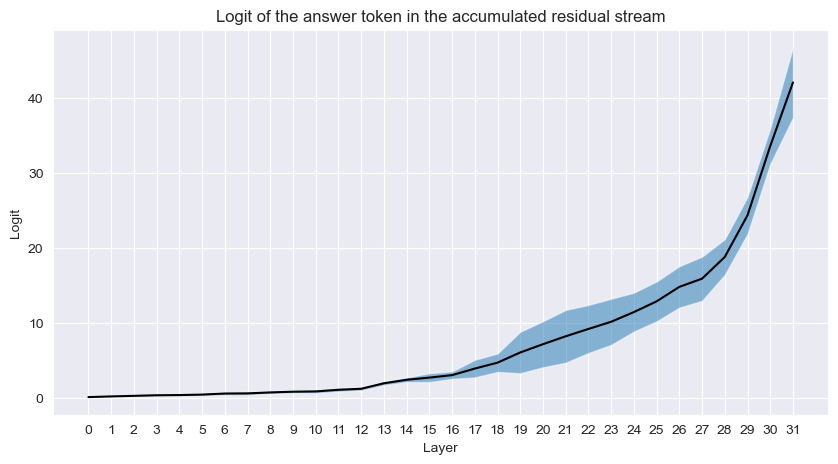

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Logit of the answer token in the accumulated residual stream")
plt.xlabel("Layer")
plt.ylabel("Logit")
plt.fill_between(list(answer_logits.keys()), [x[0] - x[1] for x in answer_logits.values()], [x[0] + x[1] for x in answer_logits.values()], alpha=0.5)
plt.plot(list(answer_logits.keys()), [x[0] for x in answer_logits.values()], color='black')
plt.show()

This plot represents the logit value of the correct answer token at each layer at the final token `=`, averaged over 100 code expressions in the same format. So, I'm basically applying unembedding matrix at each layer at the final token and then extracting logit of the correct answer token.

It looks like nothing useful is happening in the initial 12 layers at the final token. Further, there is sharp increase in the correct token logit around layer 28.

In [8]:
modules = [f"model.layers.{i}.mlp" for i in range(model.config.num_hidden_layers)]

with TraceDict(model, modules) as residual:
    output = model(**tokenized_text)

# Compute logit of the answer token after each layer using output of each layer
answer_logits = {}
unembed = model.lm_head.weight.t()
for layer in modules:
    layer_out = residual[layer].output[:, -1]
    logits = einsum("batch d_model, d_model vocab -> batch vocab", layer_out, unembed)
    temp = []
    for bi in range(logits.shape[0]):
        temp.append(logits[bi, tokenized_answer["input_ids"][bi, 2]].item())
    answer_logits[layer.split(".")[2]] = (torch.tensor(temp).mean().item(), torch.tensor(temp).std().item())

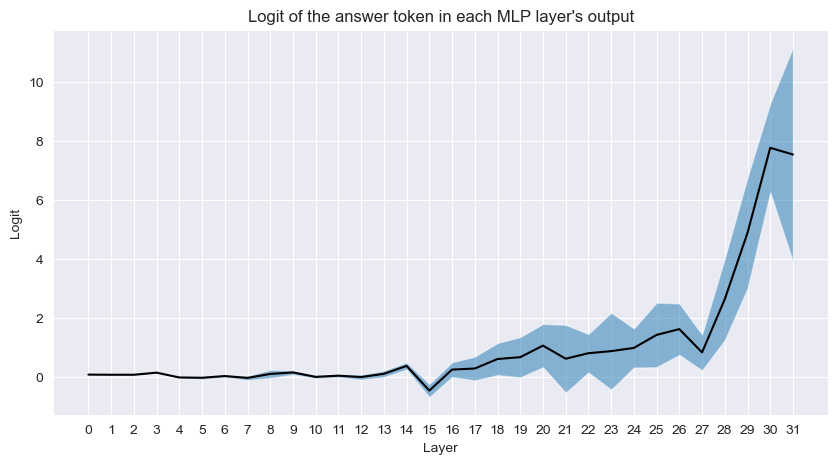

In [9]:
# Plot answer logits with fill between
plt.figure(figsize=(10, 5))
plt.title("Logit of the answer token in each MLP layer's output")
plt.xlabel("Layer")
plt.ylabel("Logit")
plt.fill_between(list(answer_logits.keys()), [x[0] - x[1] for x in answer_logits.values()], [x[0] + x[1] for x in answer_logits.values()], alpha=0.5)
plt.plot(list(answer_logits.keys()), [x[0] for x in answer_logits.values()], color='black')
plt.show()

This is similar to the previous plot, but instead of applying the unembedding matrix on the residual stream vector, here I'm transforming each layer's output.

This is interesting as it is implying that something meaningful is happening in the MLP subblock of the 27th layer. Combining the results from previous two plots, it looks like some computatoin associated with the MLP subblock is promoting the correct answer token. Probably, the model is doing the actual arithematic operation at the final mlp layers, after fetching in relevant information about the variables and operator, to produce the answer token. 

In [10]:
modules = [f"model.layers.{i}.self_attn" for i in range(model.config.num_hidden_layers)]

with TraceDict(model, modules) as residual:
    output = model(**tokenized_text)

# Compute logit of the answer after each attention layer
answer_logits = {}
unembed = model.lm_head.weight.t()
for layer in modules:
    layer_out = residual[layer].output[0][:, -1]
    logits = einsum("batch d_model, d_model vocab -> batch vocab", layer_out, unembed)
    temp = []
    for bi in range(logits.shape[0]):
        temp.append(logits[bi, tokenized_answer["input_ids"][bi, 2]].item())
    answer_logits[layer.split(".")[2]] = (torch.tensor(temp).mean().item(), torch.tensor(temp).std().item())

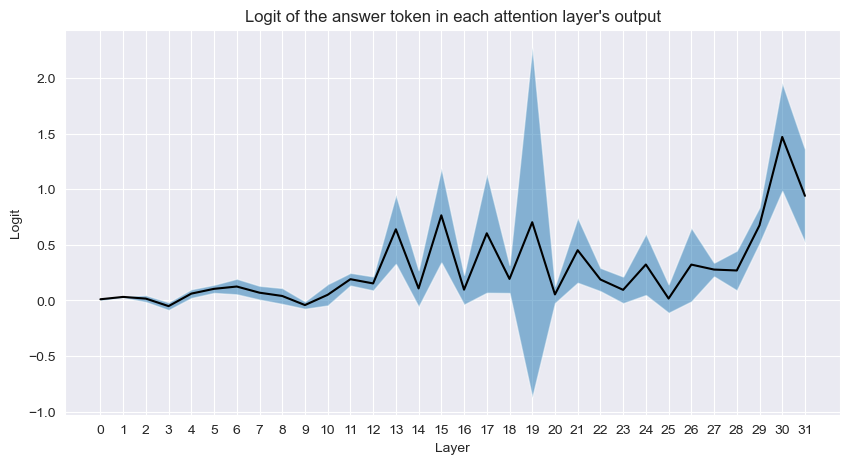

In [11]:
# Plot answer logits with fill between
plt.figure(figsize=(10, 5))
plt.title("Logit of the answer token in each attention layer's output")
plt.xlabel("Layer")
plt.ylabel("Logit")
plt.fill_between(list(answer_logits.keys()), [x[0] - x[1] for x in answer_logits.values()], [x[0] + x[1] for x in answer_logits.values()], alpha=0.5)
plt.plot(list(answer_logits.keys()), [x[0] for x in answer_logits.values()], color='black')
plt.show()

Here, I'm applying the unembedding matrix on the output of the activation subblock and then extracting the logit of correct answer token.

First, it's interesting to notice the change in the y-axis scale. It's significantly smaller than the previous two plots, suggesting that may be attention subblock is not directly involved in promoting the correct answer token in the final token residual stream. Second, there seems to be a increment in the correct answer logit value at layer 29. I believe it might be due to the presence of attention heads that are just attenting to the final token (explored in next section), rather than any other previous tokens in the context. And since, the residual stream vector already has significant information about the correct answer token (from previous plots), output of the attention subblocks in the later layers may be encode information about the correct answer token.

### Attention Analysis

Let's explore the attention pattern at the final token of later layers, to check if there are attention heads that are attending to the same final token and hence encoding the correct answer token in their respective attention subblocks.

In [4]:
def apply_causal_mask(attn_scores):
    """Apply a causal mask to attention scores."""
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()
    attn_scores.masked_fill_(mask, ignore)
    return attn_scores


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    """Applies rotary positional embedding to attention scores."""
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def get_attn_scores(model, tokenized_text, layer):
    """Get attention scores for a given layer."""
    modules = [
        [f"model.layers.{i}.self_attn.k_proj", f"model.layers.{i}.self_attn.q_proj", f"model.layers.{i}.self_attn.v_proj"] 
        for i in range(model.config.num_hidden_layers)
    ]
    modules = [item for sublist in modules for item in sublist]

    with TraceDict(model, modules) as residual:
        model(**tokenized_text)

    batch_size, seq_len = tokenized_text['input_ids'].shape
    n_heads = model.config.num_attention_heads
    d_head = model.config.hidden_size//n_heads

    key = residual[f"model.layers.{layer}.self_attn.k_proj"].output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
    query = residual[f"model.layers.{layer}.self_attn.q_proj"].output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
    value = residual[f"model.layers.{layer}.self_attn.v_proj"].output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)

    kv_seq_len = key.shape[-2]
    cos, sin = model.model.layers[layer].self_attn.rotary_emb(value, seq_len=kv_seq_len)
    positions = [i for i in range(seq_len)]
    positions = torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
    query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

    attn_scores = einsum("batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos", 
                        key, query)
    attn_scores = attn_scores/math.sqrt(d_head)
    attn_scores = apply_causal_mask(attn_scores)
    attn_scores = torch.softmax(attn_scores, dim=-1)
    return attn_scores

In [13]:
text = "x=2\ny=5\nx+y="
tokenized_text = tokenizer(text, return_tensors='pt').to(device)
attn_scores = get_attn_scores(model, tokenized_text, layer=30)
pysvelte.AttentionMulti(tokens=[tokenizer.decode(token) for token in tokenized_text['input_ids'][0].tolist()], 
                        attention=attn_scores[0].permute(1, 2, 0)).show()

At layer 30, the combined attention score of all the heads at the final token seem to have dominant attendance on itself. There are individual heads that are specifically attending to the final token: `31.1`, `31.14`, `31.22`, `31.25`. I think this bolsters my previous reasoning for why are we observing an increment in the correct answer logit at the final layers' attention subblock output. But I think more investigation is needed to determine what is exactly happening in the final MLP subblocks.

### Activation Patching

So far, we have seen that mlp subblocks at the later layers are significantly promoting the correct answer token at the final token residual stream. So, what might be happening in those mlp subblocks? Since, mlp subblocks are primarily responsible to storing associations rather than moving information in the network, my hypothesis is that the mlp subblocks at the later layers are actually doing the arithematic operation (`x+y`) and consequently promoting the correct answer token. For that to happen, the residual stream should already have the required information to do the operation, i.e. the variables and operator in the final operation statement as well as the numerical values of the variables. Since, attention subblocks are responsible for moving information between different tokens' residual stream, I believe somehow all the required information are getting transferred to the final token residual stream via attention heads of the initial or middle layers.

So, my hypothesis for the circuit involved in arithmetic operation: Attention heads in the initial and/or middle layers are fetching all the required information in the final token residual stream and then the final mlp subblocks are computing the answer token using those information.

To investigate this hypothesis and come up with the circuit, I'll use and extend activation patching as introduced in the [ROME paper](rome.baulab.info). In addition to the residual, mlp, and attention layer patching, I've also implemented attention head patching in which output of a single head is patched into the corrupted state to check how influential that head is in restoring the information of the corrupted token.

In [8]:
def plot_trace_heatmap(model, result, savepdf=None, title=None, xlabel=None, modelname=None):
    """Plots the causal tracing heatmap. It is copied from the original ROME codebase 
    and extended to incorporate patching individual heads."""

    low_score = result["low_score"]
    subject_range = result["subject_range"]
    subject = result['subject']
    answer = result['answer']
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    if kind == "head":
        differences = torch.flip(result['scores'], dims=(0, ))
        tokens = result['input_tokens'][::-1]
    else:
        differences = torch.transpose(result["scores"], 0, 1)
        tokens = result['input_tokens']

    correct_output = (
        'correct' if low_score > 0 else 'incorrect'
    )

    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context():
        if kind == "head":
            fig, ax = plt.subplots(figsize=(30, 5))
            h = ax.pcolor(
                differences,
                cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds", "head": "Reds"}[
                    kind
                ],
                vmin=low_score,
            )
            ax.set_xticks([i for i in range(0, differences.shape[1], model.config.num_attention_heads)])
            ax.set_xticklabels(f'{i//model.config.num_attention_heads+1}' for i in range(0, differences.shape[1], model.config.num_attention_heads))
            ax.set_yticks([i+0.5 for i in range(0, differences.shape[0])])
            ax.set_yticklabels(tokens)
            # add vertical lines to show layer boundaries
            for i in range(1, model.config.num_hidden_layers):
                ax.axvline(i*model.config.num_attention_heads, color='k', linewidth=0.2)
        else:
            fig, ax = plt.subplots(figsize=(10, 8))
            h = ax.pcolor(
                differences,
                cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                    kind
                ],
                edgecolors='k',
                vmin=low_score,
            )
            ax.set_yticks([i+0.5 for i in range(0, differences.shape[0])])
            ax.set_yticklabels(f'layer {i+1}' for i in range(0, differences.shape[0]))
            ax.set_xticks([i+0.5 for i in range(0, differences.shape[1])])
            ax.set_xticklabels(tokens)
        if not modelname:
            modelname = model.name_or_path
        if not kind:
            ax.set_title(f"Impact of restoring state after corrupting embedding of token '{subject}' at {subject_range}")
            ax.set_xlabel('Token Ids')
        else:
            if kind == "mlp":
                kindname = "MLP"
            elif kind == "attn":
                kindname = "Attn"
            elif kind == "head":
                kindname = "Head"
            ax.set_title(f"Impact of restoring {kindname} after corrupting embedding of token '{subject}' at {subject_range}")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        cb.ax.set_title(f"p({answer})", y=-0.16)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [9]:
prompt = "x=2\ny=5\nx+y="
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

In [23]:
# The following code will generate and store heatmaps of the causal trace for each token in the input sequence.
# Heatmaps for residual, mlp, attention will be generated.
# It will take some time to run 

for kind in [None, "attn", "mlp"]:
    for token_position in tqdm(range(0, inputs['input_ids'].shape[1]), desc='token position'):
        token = inputs['input_ids'][0, token_position]
        subject = tokenizer.decode(token)
        result = plot_all_flow(model, tokenizer, prompt, subject, token_position, kinds=[kind])
        directory = "residual" if kind is None else kind
        plot_trace_heatmap(model, result, savepdf=f'../plots/{directory}/{token_position}.png')

The following plots show the influential attention subblocks that are responsible for moving numerical value tokens for `x` and `y` variables into the final token residual stream. Some observations:
1. Numerical values are getting transferred from their respective residual stream to the final token residual stream directly.
2. Influential attention subblocks are in the middle layers, consistent with my hypothesis.

For now, let's dive deep into how numerical values are fetched into the final token residual stream by figuring out the influential attention heads that are responsible for it.

![attn](./plots/attn/3.png)
![attn](./plots/attn/7.png)

In [13]:
# The following code will generate causal tracing plots for individual heads.
# Since it takes significant amount of time to run, I only ran it for a few tokens.

# results = {}
for token_position in tqdm([10], desc='token position'):
    token = inputs['input_ids'][0, token_position]
    subject = tokenizer.decode(token)
    results[token_position] = plot_all_flow(model, tokenizer, prompt, subject, token_position, kinds=["head"])
    plot_trace_heatmap(model, results[token_position], savepdf=f'../plots/head/{token_position}.png')

token position: 100%|██████████| 1/1 [11:23<00:00, 683.79s/it]


The following plots identifies the influential attention heads that are responsible for moving the numerical value information in the network. Y-axis represents the tokens and x-axis represents individual heads. Vertical lines separate heads by layers. In addition to the heads in the middle layers of the final token residual stream, there are some heads in the residual stream of the corrupted token. Maybe those heads are writing to a subspace in their residual stream that heads in the final token position are reading from to get numerical values.

Let's checkout where the influential heads at the corrupted token are attending and also explore what other influential heads are attending to using attention patterns.

![head](./plots/head/3.png)
![head](./plots/head/7.png)

In [39]:
k = 10
for token_position in [3, 7]:
    print(f'Most influential attention heads when corrupt token position is {token_position}.')
    top_k_values, top_k_indices = results[token_position]['scores'].flatten().topk(k)
    top_k_indices_2d = torch.stack((top_k_indices // results[token_position]['scores'].shape[1], top_k_indices % results[token_position]['scores'].shape[1]), dim=1)
    top_k_heads = top_k_indices_2d[:, 1] % model.config.num_attention_heads
    top_k_indices_2d[:, 1] = top_k_indices_2d[:, 1] // model.config.num_attention_heads
    top_k_indices_3d = torch.stack((top_k_indices_2d[:, 0], top_k_indices_2d[:, 1], top_k_heads), dim=1)
    for head_pos in top_k_indices_3d:
        print(f"Token pos: {head_pos[0]}, layer: {head_pos[1]}, head: {head_pos[2]}")

Most influential attention heads when corrupt token position is 3.
Token pos: 12, layer: 15, head: 23
Token pos: 12, layer: 13, head: 2
Token pos: 12, layer: 15, head: 9
Token pos: 3, layer: 6, head: 24
Token pos: 12, layer: 19, head: 1
Token pos: 4, layer: 2, head: 31
Token pos: 12, layer: 12, head: 9
Token pos: 12, layer: 15, head: 13
Token pos: 12, layer: 16, head: 28
Token pos: 12, layer: 17, head: 8
Most influential attention heads when corrupt token position is 7.
Token pos: 12, layer: 13, head: 15
Token pos: 7, layer: 6, head: 24
Token pos: 12, layer: 14, head: 19
Token pos: 12, layer: 17, head: 25
Token pos: 7, layer: 11, head: 11
Token pos: 12, layer: 15, head: 9
Token pos: 12, layer: 19, head: 14
Token pos: 12, layer: 19, head: 1
Token pos: 7, layer: 9, head: 16
Token pos: 12, layer: 17, head: 22


In [16]:
text = "x=2\ny=5\nx+y="
tokenized_text = tokenizer(text, return_tensors='pt').to(device)
attn_scores = get_attn_scores(model, tokenized_text, layer=15)
pysvelte.AttentionMulti(tokens=[tokenizer.decode(token) for token in tokenized_text['input_ids'][0].tolist()], 
                        attention=attn_scores[0].permute(1, 2, 0)).show()

Some oberservations:
1. Most of the influential heads that are not in the final token residual stream are attending to the corrupted token, i.e. numerical value tokens.
2. Further, most of the influential heads at the final token are attending to the token position that have other influential heads.

These two observations bolster my hypothesis that the heads at previous token positions are writing to a subspace in their residual stream that heads in the final token position are reading from to get numerical values. However, I still feel that further analysis is needed to confirm it. For instance, decomposing attention heads into *QK* and *OV* circuits, and figuring out which is more important for influential heads at the early tokens vs. in the final tokens, would provide further insight. I believe for the influential heads in the early token, *OV* circuit would be more important since their primary task (based on my hypothesis) is to transfer numerical value information. Whereas for the influential heads at the final token, *QK* would be more important since their primary task would be to decide where to bring information from.

The following plots identifies the influential attention heads that are responsible for transferring the variable names from the last code statement to the final token residual stream. Some observations:
1. Influential heads involved in transferring both variable names are still in the initial or middle layers, consistent with my hypothesis that initial-middle layers are bringing vital information and final mlp layers are doing the operation.
2. For variable `y`, heads at the final tokens are directly retrieving the information. However, for variable `x`, things are looking more involved than that. Maybe, it's information is first getting transferred to `+` or `y` variable residual stream and then finally to the last token residual stream.

![head](./plots/head/9.png)
![head](./plots/head/11.png)

In [14]:
k = 10
for token_position in [9, 10, 11]:
    print(f'Most influential attention heads when corrupt token position is {token_position}.')
    top_k_values, top_k_indices = results[token_position]['scores'].flatten().topk(k)
    top_k_indices_2d = torch.stack((top_k_indices // results[token_position]['scores'].shape[1], top_k_indices % results[token_position]['scores'].shape[1]), dim=1)
    top_k_heads = top_k_indices_2d[:, 1] % model.config.num_attention_heads
    top_k_indices_2d[:, 1] = top_k_indices_2d[:, 1] // model.config.num_attention_heads
    top_k_indices_3d = torch.stack((top_k_indices_2d[:, 0], top_k_indices_2d[:, 1], top_k_heads), dim=1)
    for head_pos in top_k_indices_3d:
        print(f"Token pos: {head_pos[0]}, layer: {head_pos[1]}, head: {head_pos[2]}")

Most influential attention heads when corrupt token position is 9.
Token pos: 12, layer: 12, head: 23
Token pos: 12, layer: 15, head: 23
Token pos: 10, layer: 2, head: 31
Token pos: 11, layer: 9, head: 14
Token pos: 10, layer: 4, head: 22
Token pos: 10, layer: 1, head: 29
Token pos: 10, layer: 7, head: 7
Token pos: 12, layer: 11, head: 23
Token pos: 12, layer: 10, head: 27
Token pos: 12, layer: 15, head: 9
Most influential attention heads when corrupt token position is 10.
Token pos: 12, layer: 17, head: 22
Token pos: 12, layer: 12, head: 18
Token pos: 11, layer: 1, head: 8
Token pos: 12, layer: 11, head: 29
Token pos: 12, layer: 7, head: 5
Token pos: 12, layer: 20, head: 18
Token pos: 12, layer: 15, head: 30
Token pos: 12, layer: 16, head: 28
Token pos: 11, layer: 6, head: 23
Token pos: 12, layer: 21, head: 24
Most influential attention heads when corrupt token position is 11.
Token pos: 12, layer: 7, head: 23
Token pos: 12, layer: 1, head: 29
Token pos: 12, layer: 17, head: 22
Token 

### Causal Intervention

Since, I've been able to locate the heads that are transferring numerical value information into the final token residual stream, it would be interesting to make causal intervention on the output of those heads. Specially, if I replace the output the influential heads in code expression, from their output in a different code expression, with different numerical values, would the final predicted answer token change? 

In [77]:
def replace_activations(top_heads, corrupt_residual):
    """This function will replace the activations of the top heads with the 
    original code expression with that of a different code expression."""

    def substitute(inputs, residual, layer):
        d_head = model.config.hidden_size // model.config.num_attention_heads
        layer_idx = int(layer.split('.')[2])

        for pos in top_heads.keys():
            heads = [int(head.split('.')[1]) for head in top_heads[pos] if int(head.split('.')[0].split('_')[1]) == layer_idx]
            for head_idx in heads:
                head_start = head_idx * d_head
                head_end = (head_idx + 1) * d_head
                inputs[0][:, pos, head_start:head_end] = corrupt_residual[layer].input[:, pos, head_start:head_end]
        
        output = einsum("batch position hidden_size, d_model hidden_size -> batch position d_model",
                            inputs[0], model.model.layers[int(layer.split('.')[2])].self_attn.o_proj.weight)
        return output
    return substitute

In [115]:
# Top heads involved in tranferring y's numerical values, 
# identified using causal tracing at head level
top_heads_x = {}
# top_heads_x[3] = ["layer_6.24"]
# top_heads_x[4] = ["layer_2.31"]
top_heads_x[12] = ["layer_15.23", "layer_13.2", "layer_15.9", "layer_19.1", "layer_12.9",
                   "layer_15.13", "layer_16.28", "layer_17.8"]

org_text = "x=2\ny=5\nx+y="
diff_text = f"x=3\ny=5\nx+y="
org_tokenized_text = tokenizer(org_text, return_tensors='pt').to(device)
diff_tokenized_text = tokenizer(diff_text, return_tensors='pt').to(device)

# Running the model with original code expression.
output = model(**org_tokenized_text)
prob, pred = torch.max(output.logits[:, -1], dim=-1)
print(f"Output of original code expression: {tokenizer.decode(pred[0].item())}, Logit: {prob[0].item()}")

# Running the model with different code expression to get top attention heads output.
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(model.config.num_hidden_layers)]
with TraceDict(model, modules, retain_input=True) as corrupt_residual:
    output = model(**diff_tokenized_text)
prob, pred = torch.max(output.logits[:, -1], dim=-1)
print(f"Output of different code expression: {tokenizer.decode(pred[0].item())}, Logit: {prob[0].item()}")

# Running the model with original code expression and replacing the activations of top heads attenting to x's numerical value
# with those of different code expression.
with TraceDict(model, modules, retain_input=True, edit_output=replace_activations(top_heads_x, corrupt_residual)) as trace:
    output = model(**org_tokenized_text)
logits = output.logits[0, -1, :]
prob, pred = torch.max(logits, dim=-1)
print(f"Output of the original code expression with top heads attending to x's numerical value patched: {tokenizer.decode(pred.item())}, Logit: {prob.item()}\n")

Output of original code expression:  7, Logit: 14.48103141784668
Output of different code expression:  8, Logit: 15.972633361816406
Output of the original code expression with top heads attending to x's numerical value patched:  8, Logit: 15.016656875610352



In [117]:
top_heads_y = {}
# top_heads_y[7] = ["layer_6.24", "layer_11.11", "layer_9.16"]
top_heads_y[12] = ['layer_13.15', 'layer_14.19', 'layer_17.25', 'layer_15.9', 
                   'layer_19.14', 'layer_19.1', 'layer_17.22']

org_text = "x=3\ny=5\nx+y="
diff_text = f"x=3\ny=4\nx+y="
org_tokenized_text = tokenizer(org_text, return_tensors='pt').to(device)
diff_tokenized_text = tokenizer(diff_text, return_tensors='pt').to(device)

# Running the model with original code expression.
output = model(**org_tokenized_text)
prob, pred = torch.max(output.logits[:, -1], dim=-1)
print(f"Output of original code expression: {tokenizer.decode(pred[0].item())}, Logit: {prob[0].item()}")

# Running the model with different code expression to get top attention heads output.
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(model.config.num_hidden_layers)]
with TraceDict(model, modules, retain_input=True) as corrupt_residual:
    output = model(**diff_tokenized_text)
prob, pred = torch.max(output.logits[:, -1], dim=-1)
print(f"Output of different code expression: {tokenizer.decode(pred[0].item())}, Logit: {prob[0].item()}")


# Running the model with original code expression and replacing the activations of top heads attenting to y's numerical value
# with those of different code expression.
with TraceDict(model, modules, retain_input=True, edit_output=replace_activations(top_heads_y, corrupt_residual)) as trace:
    output = model(**org_tokenized_text)
logits = output.logits[0, -1, :]
prob, pred = torch.max(logits, dim=-1)
print(f"Output of the original code expression with top heads attending to y's numerical value patched: {tokenizer.decode(pred.item())}, Logit: {prob.item()}")

Output of original code expression:  8, Logit: 15.972633361816406
Output of different code expression:  7, Logit: 14.873213768005371
Output of the original code expression with top heads attending to y's numerical value patched:  7, Logit: 14.176610946655273


It's fascinating to see that there are just a handful of attention heads in the entire network, that are responsible for tranferring numerical value information to the final token residual stream. Some observations:
1. I don't need to patch in the outputs of the influential heads in the previous tokens, i.e. patching the top influential heads in the final token position is sufficient to get the causal effect. This again suggest my previous hypothesis, that attention heads at the final token position are reading from the same subspace that the influential heads in the previous token positions are writing to.
2. I noticed that when both x and y numerical values are different, patching the output of influential heads do not result in correct final answer. I'm not sure why that might be happening. My random guess is probably too much of information patching might be confusing the network.

### Consolidating

So, till now I've been able to figure out the following about the circuit involved in the code expression evaluation:
1. All vital information, including variable names and operator in the final arithematic statement as well as variable's numerical values, are getting fetched to the final token residual stream in the initial or middle layers.
2. MLP subblocks in the final layers seem to be utilizing these information to produce the final answer token.
3. Numerical values of the variables are getting transferred to the final token residual stream directly, via a set of handful attention heads. Influential heads in the final token position might be reading information from the same subspace that influential heads in the previous token positions are writing to.